# Cargar el modelo

In [33]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from src.models.efficientnet import EfficientNetB5Custom
from src.grad_cam import GradCAM
model_state = torch.load('models/efficientnet/best_model_EfficientNetB5Custom_epoch_0.pt',map_location=torch.device('cpu'))
model = EfficientNetB5Custom(num_classes=5, pretrained=False)

model.load_state_dict(model_state)

model.eval()
target_layer = model.efficientnet.features[-1]

grad_cam = GradCAM(model, target_layer)

c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


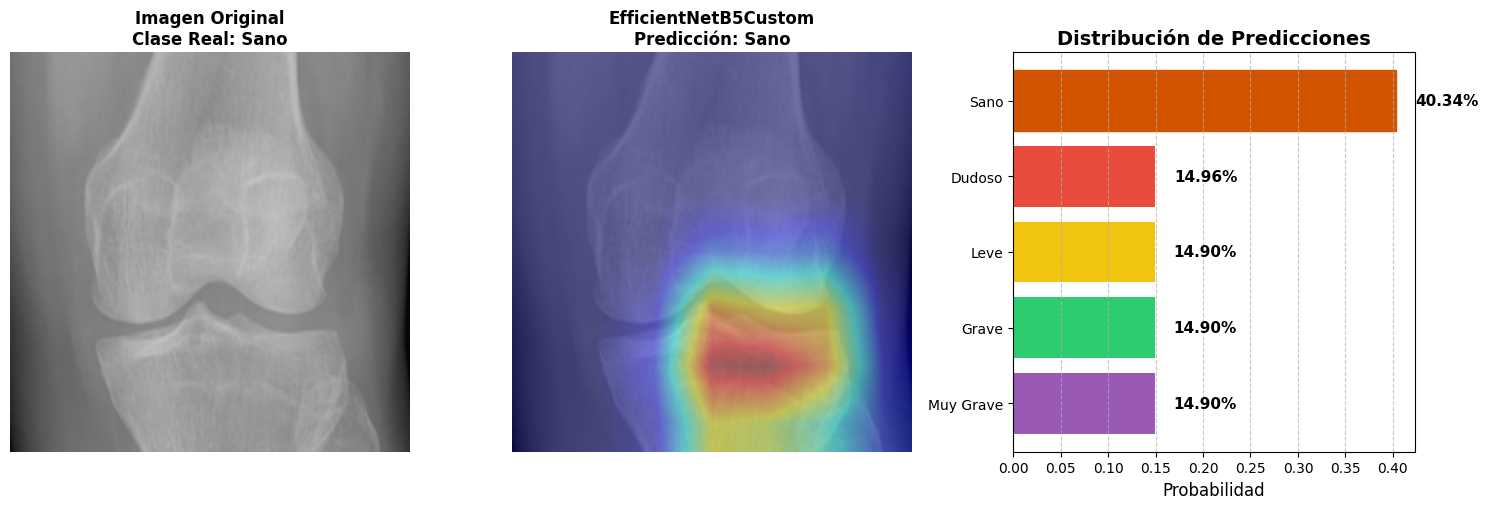

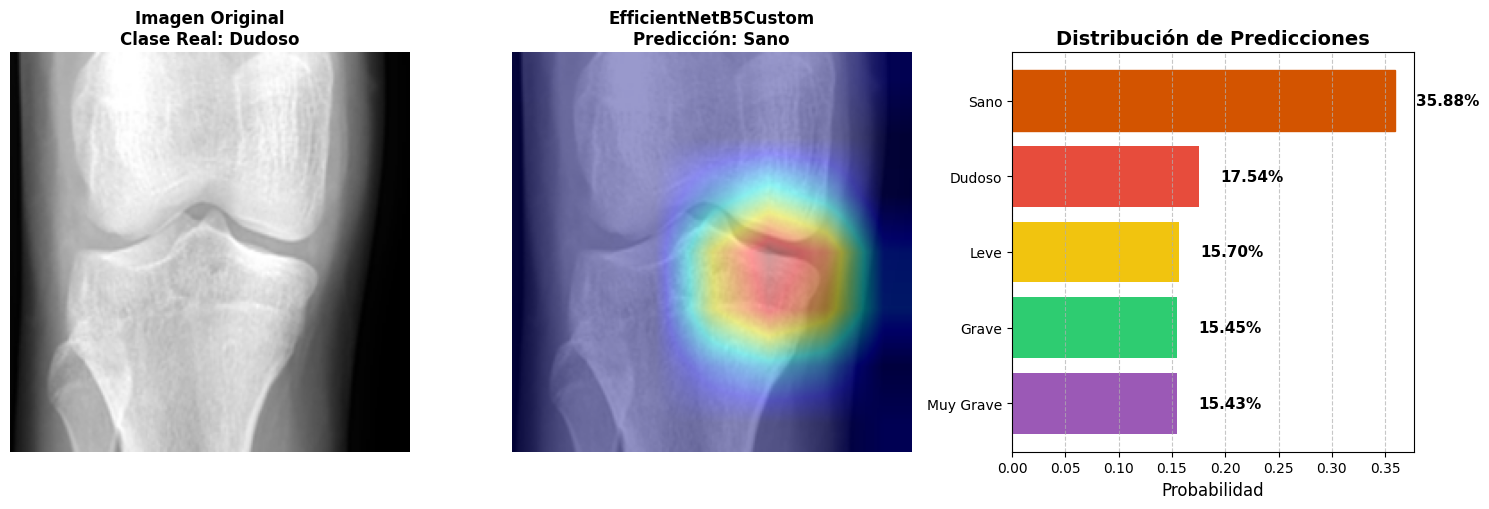

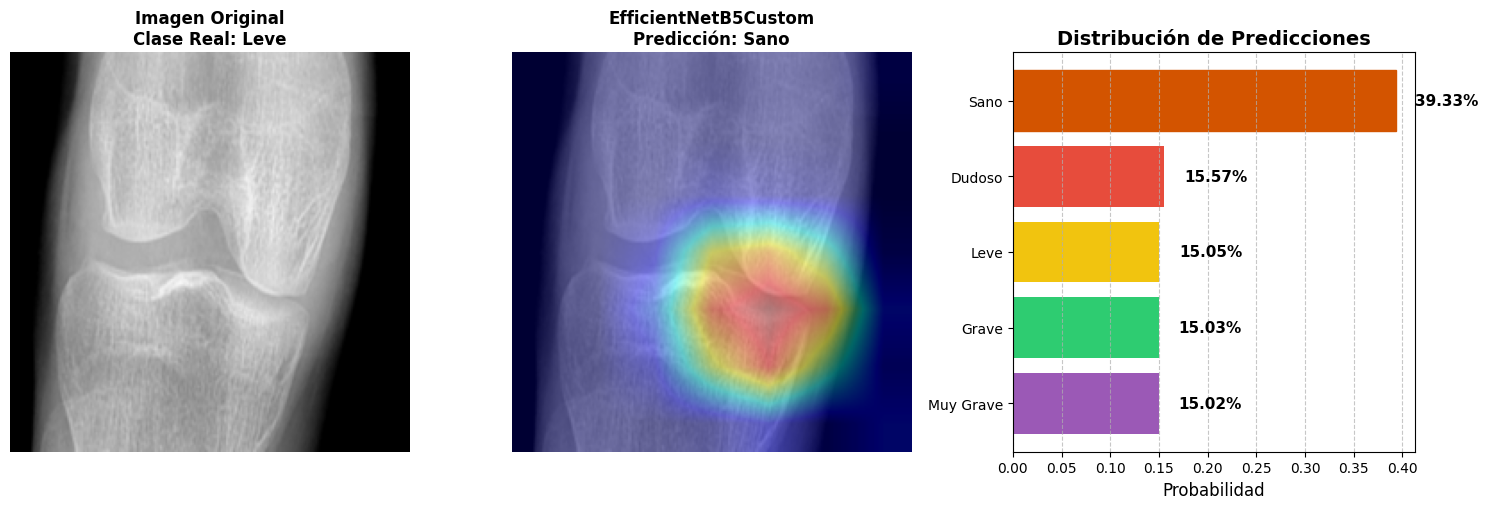

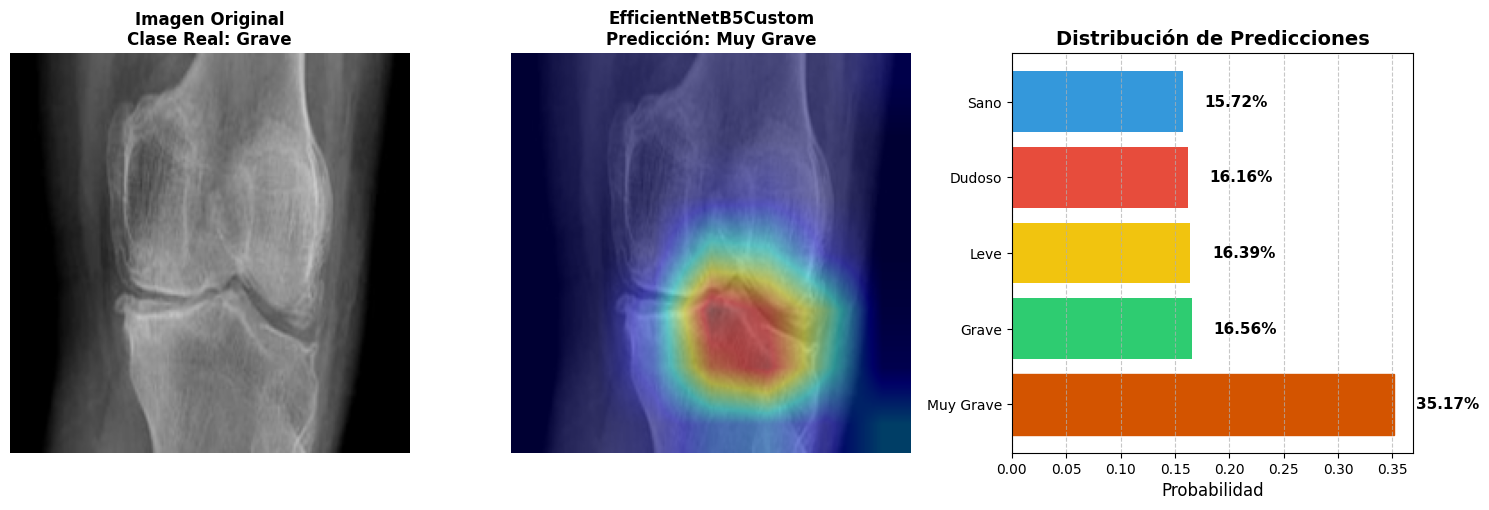

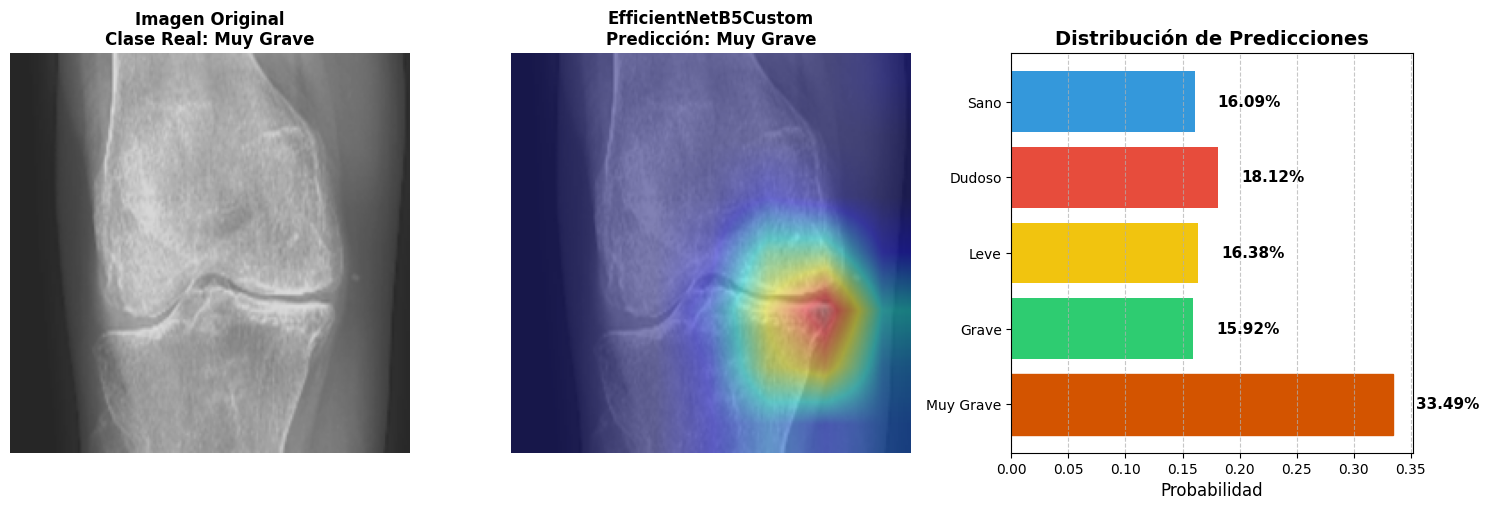

In [43]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from src.config import MENDELEY_EXPERT1_PATH

# Diccionario de clases (ajústalo según tu dataset)
idx_to_class = {0: "Sano", 1: "Dudoso", 2: "Leve", 3: "Grave", 4: "Muy Grave"}

# Obtener rutas de imágenes y clases reales
dataset_path = MENDELEY_EXPERT1_PATH
img_paths = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img_paths.append((image_path, class_name))
        break  # Solo tomar una imagen por clase

# Procesar y predecir cada imagen
for img, real_class in img_paths:
    # Cargar la imagen
    imagen = Image.open(img).convert('RGB')

    # Transformaciones (ajustar según el modelo)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(imagen).unsqueeze(0)  # Añadir batch dimension

    # **Obtener la predicción del modelo**
    with torch.no_grad():
        output = model(input_tensor)  # Salida del modelo (logits)
        probabilities = F.softmax(output, dim=1).squeeze(0)  # Aplicar softmax y aplanar
        predicted_idx = probabilities.argmax().item()  # Índice de la clase con mayor probabilidad
        predicted_class = idx_to_class.get(predicted_idx, str(predicted_idx))  # Convertir índice a nombre de clase

    # **Generar Grad-CAM**
    cam = grad_cam.generate_cam(input_tensor)

    # Convertir el Grad-CAM a una imagen de OpenCV
    cam = cv2.resize(cam, (224, 224))  # Ajustar tamaño
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Colormap Grad-CAM
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB

    # Convertir imagen original en numpy para combinarla con Grad-CAM
    image_np = np.array(imagen.resize((224, 224)))
    superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # **Crear figura con 3 subplots: Imagen Original, Grad-CAM y Probabilidades**
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    ax[0].imshow(image_np)
    ax[0].set_title(f"Imagen Original\nClase Real: {idx_to_class[int(real_class)]}", fontsize=12, fontweight="bold")
    ax[0].axis("off")

    # Imagen con Grad-CAM
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"{model.name}\nPredicción: {predicted_class}", fontsize=12, fontweight="bold")
    ax[1].axis("off")

    # **Gráfica de distribución de predicciones con diseño mejorado**
    class_names = list(idx_to_class.values())
    bars = ax[2].barh(class_names, probabilities.numpy(), color=["#3498db", "#e74c3c", "#f1c40f", "#2ecc71", "#9b59b6"])
    
    # Resaltar la clase con mayor probabilidad
    max_index = predicted_idx
    bars[max_index].set_color("#d35400")

    # Etiquetas y diseño
    ax[2].set_xlabel("Probabilidad", fontsize=12)
    ax[2].set_title("Distribución de Predicciones", fontsize=14, fontweight="bold")
    ax[2].invert_yaxis()  # Para que la clase con mayor probabilidad aparezca arriba
    ax[2].grid(axis="x", linestyle="--", alpha=0.7)

    # Mostrar valores sobre las barras
    for bar in bars:
        width = bar.get_width()
        ax[2].text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2%}", 
                   va="center", fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.show()



In [ ]:
grad_cam.generate_cam('data/val/COVID19/COVID19(1).jpg', 'grad_cam/COVID19(1).jpg')